This is a Neo4j Graph based chatbot which will solve any other queries the user might have

#Imports

In [83]:
!pip install langchain_community
!pip install langchain_neo4j
!pip install neo4j
!pip install langchain_experimental
!pip install langchain_groq
!pip install langchain_openai

API Keys

Importing the reports

In [85]:
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
rcts=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

doc_1=TextLoader("/content/abnormalities (1).md")
doc_1= doc_1.load()
doc_1=rcts.split_documents(doc_1)

doc_2=TextLoader("/content/doctors.md")
doc_2= doc_2.load()
doc_2=rcts.split_documents(doc_2)

doc_3=TextLoader("/content/explained_report.md")
doc_3= doc_3.load()
doc_3=rcts.split_documents(doc_3)

doc=doc_1 + doc_2 + doc_3

In [86]:
doc

[Document(metadata={'source': '/content/abnormalities (1).md'}, page_content="# Abnormalities Report for Mr. DUMMY\n\n## Overview\nThis report analyzes the abnormal values identified in Mr. DUMMY's recent medical tests. It aims to highlight the potential health risks, explain the significance of these values, provide tailored recommendations, and assess the urgency of clinical consultation.\n\n---\n\n## Abnormal Values Summary"),
 Document(metadata={'source': '/content/abnormalities (1).md'}, page_content='---\n\n## Abnormal Values Summary\n\n### 1. Globulin (Calculated)\n- **Result:** 4.00 g/dL \n- **Bio. Reference Interval:** 2.0 - 3.5 g/dL \n- **Classification:** Abnormal \n- **Severity Score:** Moderate (2)\n  \n**Significance:**\nElevated globulin levels may indicate chronic inflammatory diseases, liver diseases, or certain infections.'),
 Document(metadata={'source': '/content/abnormalities (1).md'}, page_content='**Recommendations:**\n- **Monitor Globulin Levels:** Regular testi

Converting the graph to a neo4j knowledge graph

In [87]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
graph_llm= LLMGraphTransformer(llm)

graph_docs=graph_llm.convert_to_graph_documents(doc)

In [88]:
graph_docs[0]

GraphDocument(nodes=[Node(id='Mr. Dummy', type='Person', properties={})], relationships=[Relationship(source=Node(id='Mr. Dummy', type='Person', properties={}), target=Node(id='Abnormal Values', type='Medical condition', properties={}), type='HAS', properties={})], source=Document(metadata={'source': '/content/abnormalities (1).md'}, page_content="# Abnormalities Report for Mr. DUMMY\n\n## Overview\nThis report analyzes the abnormal values identified in Mr. DUMMY's recent medical tests. It aims to highlight the potential health risks, explain the significance of these values, provide tailored recommendations, and assess the urgency of clinical consultation.\n\n---\n\n## Abnormal Values Summary"))

In [89]:
from langchain_community.graphs import Neo4jGraph
graph=Neo4jGraph()

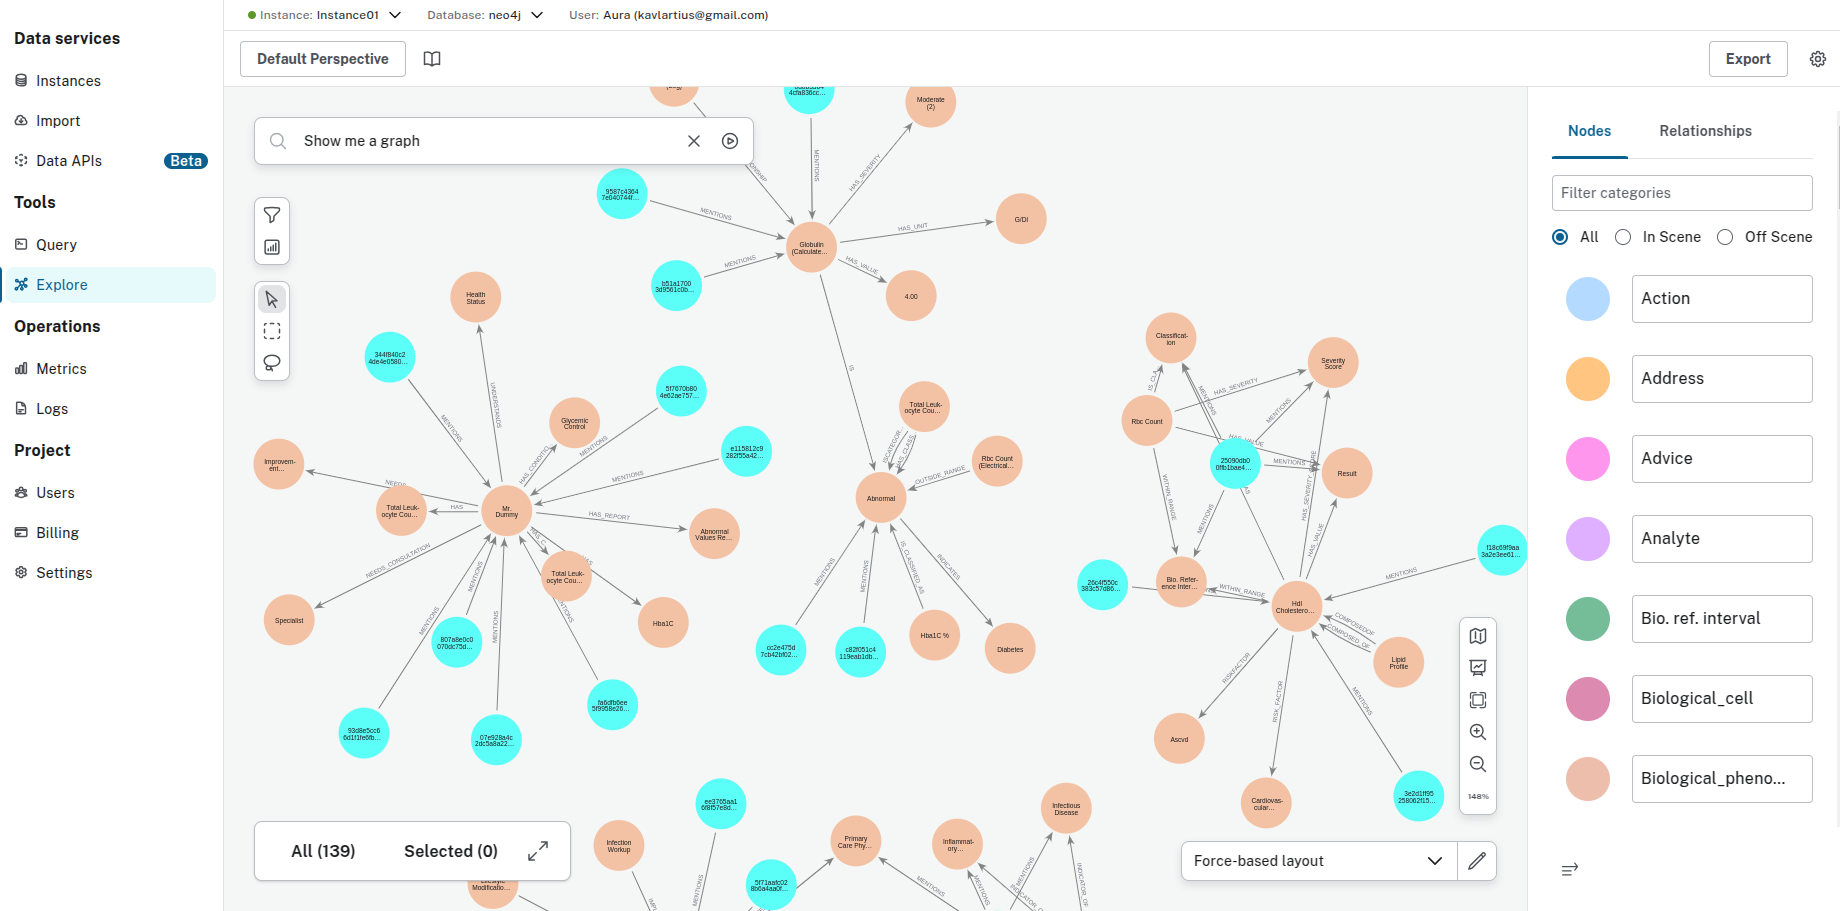

In [90]:
graph.add_graph_documents(
    graph_documents=graph_docs,
    baseEntityLabel=True,
    include_source=True
)

In [91]:
from langchain_openai import OpenAIEmbeddings
embeddings=OpenAIEmbeddings()

In [92]:
from langchain_community.vectorstores.neo4j_vector import Neo4jVector

In [93]:
graph_docs[0]

GraphDocument(nodes=[Node(id='Mr. Dummy', type='Person', properties={})], relationships=[Relationship(source=Node(id='Mr. Dummy', type='Person', properties={}), target=Node(id='Abnormal Values', type='Medical condition', properties={}), type='HAS', properties={})], source=Document(metadata={'source': '/content/abnormalities (1).md', 'id': '07e928a4c2dc5a8a222b7b9bf1317fd1'}, page_content="# Abnormalities Report for Mr. DUMMY\n\n## Overview\nThis report analyzes the abnormal values identified in Mr. DUMMY's recent medical tests. It aims to highlight the potential health risks, explain the significance of these values, provide tailored recommendations, and assess the urgency of clinical consultation.\n\n---\n\n## Abnormal Values Summary"))

Graph Vector DB

In [94]:
db=Neo4jVector.from_existing_graph(
    embedding=embeddings,
    node_label="Document",
    text_node_properties=['source','text'],
    embedding_node_property='embedding',
    search_type='hybrid'
)

In [107]:
db.similarity_search_with_score("Urea")

[(Document(metadata={}, page_content='\nsource: /content/explained_report.md\ntext: | Urea (Urease UV)                     | 40.00   | mg/dL    | 13.00 - 43.00         | Normal         | 0              |\n| Urea Nitrogen Blood (Calculated)     | 18.68   | mg/dL    | 6.00 - 20.00          | Normal         | 0              |\n| BUN/Creatinine Ratio (Calculated)    | 19      |          |                       | Normal         | 0              |\n| Uric Acid (Uricase)                  | 7.00    | mg/dL    | 3.50 - 7.20           | Normal         | 0              |'),
  1.0),
 (Document(metadata={}, page_content='\nsource: /content/report.md\ntext: | Urea (Urease UV)                     | 40.00   | mg/dL   | 13.00 - 43.00         |\n| Urea Nitrogen Blood (Calculated)     | 18.68   | mg/dL   | 6.00 - 20.00          |\n| BUN/Creatinine Ratio (Calculated)    | 19      |         |                        |\n| Uric Acid (Uricase)                  | 7.00    | mg/dL   | 3.50 - 7.20           |\n| A

Converting this db to a retriever and implementing a chatbot.

1. This chatbot will have access to a search engine

Retriever as a tool

In [96]:
from langchain.tools.retriever import create_retriever_tool
retriever=db.as_retriever()
tool=create_retriever_tool(retriever,"Patient_Records_and_Recommendations_Tool","This tool stores patient information, including medical records, suggested treatments, and recommended doctors for each patient.")

Tool_2

Chatbot LLM

In [97]:
chatbot_llm=ChatGroq(model="gemma2-9b-it")
chatbot_llm.invoke("hello")

AIMessage(content='Hello! 👋  How can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 11, 'total_tokens': 25, 'completion_time': 0.025454545, 'prompt_time': 0.001908977, 'queue_time': 0.015728053000000002, 'total_time': 0.027363522}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-c369fe5a-1073-4bf5-bd8c-d5ac69cc1aa6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 14, 'total_tokens': 25})

Prompt

In [98]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a healthcare assistant. Use the patient's health reports and the provided tool and the chat history {chat_history} to accurately answer their questions."),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

ChatBot

In [99]:
from langchain.agents import create_openai_tools_agent,AgentExecutor
agent=create_openai_tools_agent (llm=chatbot_llm,tools=[tool],prompt=prompt)
agent_exec=AgentExecutor(agent=agent,tools=[tool],verbose=False)

ChatBot History Mechanism

In [100]:
class  ChatHistory():
  def __init__(self):
    self.history_dict={}
    self.history_list=[]

  def add(self,user_input,bot_response):
    self.history_dict['user']=user_input
    self.history_dict['bot']=bot_response
    self.history_list.append(self.history_dict)
    return self.history_list

  def show(self):
    print(self.history_list)

In [101]:
test_1=ChatHistory()

In [102]:
test_1.add("hi","hello")

[{'user': 'hi', 'bot': 'hello'}]

In [103]:
test_1.show()

[{'user': 'hi', 'bot': 'hello'}]


In [104]:
history=ChatHistory()
def graph_bot(user_input):
  response=agent_exec.invoke({"input":user_input,"chat_history":history.show()})
  history.add(user_input,response)

In [108]:
graph_bot("urea")

[{'user': 'urea', 'bot': {'input': 'urea', 'chat_history': None, 'output': 'The urea nitrogen blood level is 18.68 mg/dL.  \n'}}, {'user': 'urea', 'bot': {'input': 'urea', 'chat_history': None, 'output': 'The urea nitrogen blood level is 18.68 mg/dL.  \n'}}]
